## The Trial Class

`compsyn.trial.Trial` provides a data interface for specifying "experimental metadata". This metadata can be used to logically organize the data generated for a given experiment. 

```
class Trial:
    def __init__(
        self,
        experiment_name: str,
        trial_id: str,
        hostname: Optional[str],
        trial_timestamp: Optional[str],
        work_dir: Optional[Path],
    ) -> None:
        ...
```

A `Trial` can be used to coordinate an ongoing data collection and analysis effort. For instance, running a timeseries of analysis jobs, or running analysis across multiple hosts. The `Trial` class should be used as a data class, that is - a provider of data only. The attributes of a `Trial` are:

- `experiment_name` is an overarching title for the data collection and analysis effort.

- `trial_id` can be used to further logically partition the data produced for the effort.

- `hostname` (optional) can be used to identify the host the data collection or analysis was run on.

- `trial_timestamp` This will be automatically set to the current date, or any string can be passed.

- `work_dir` This is where data generated or gathered by compsyn will be stored. A temporary directory is used if nothing is passed. (Data in temporary directories may be deleted)

All of the `trial` attributes may be configured in the host environment, as `COMPSYN_<setting_name>`, e.g. `COMPSYN_WORK_DIR`.

In [1]:
from pathlib import Path

from compsyn.trial import Trial

regional_trial = Trial(
    experiment_name="regional-differences", # COMPSYN_EXPERIMENT_NAME
    trial_id="phase-0", # COMPSYN_TRIAL_ID
    hostname="shared_notebook_user", # COMPSYN_HOSTNAME
)

[2021-03-20 22:46:15,881] (compsyn.Trial)  INFO: work_dir: /Volumes/LACIE/compsyn/data/zth
[2021-03-20 22:46:15,882] (compsyn.Trial)  INFO: experiment: regional-differences
[2021-03-20 22:46:15,882] (compsyn.Trial)  INFO: trial_id: phase-0
[2021-03-20 22:46:15,883] (compsyn.Trial)  INFO: hostname: shared_notebook_user


## The Vector Class

`compsyn.vector.Vector` provides a base class for implementing embeddings generated from any sensory input amenable to digitization. The `Vector` base class will provide methods for saving and loading `Vector` subclasses using `pickle`.

```
class Vector:
    def __init__(
        self, 
        label: str, 
        revision: Optional[str] = None, 
        trial: Optional[Trial] = None
    ) -> None:
```

All `Vector` subclasses will share these attributes:

- `label` A label for the Vector.
- `revision` (optional) A revision tag to associate when saving the vector.
- `trial` A `Trial` object to use as a source of metadata.

All `Vector` subclasses will have access to these methods:

- (property) `vector_pickle_path` returns Path to store vector pickle at.
- `save` Save the object as a pickle file.
- `load` load the object from a pickle file.
- `pull` Optionally pull data from shared S3 backend.
- `push` Optionally push data to shared S3 backend.

`Vector` subclasses, like `WordToColorVector` are left to implement their specific data collection and analysis logic. Subclassers may also extend `pull` and `push` to involve the transfer of more data besides that which is stored on the object.

For ease of use, a default `Trial` object will be created if one is not passed to `Vector` subclassers.

In [2]:
from compsyn.vectors import WordToColorVector
w2cv = WordToColorVector(label="dog")

[2021-03-20 22:46:19,632] (compsyn.Trial)  INFO: work_dir: /Volumes/LACIE/compsyn/data/zth
[2021-03-20 22:46:19,633] (compsyn.Trial)  INFO: experiment: default-experiment
[2021-03-20 22:46:19,634] (compsyn.Trial)  INFO: trial_id: local-trial
[2021-03-20 22:46:19,635] (compsyn.Trial)  INFO: hostname: topside.local


Users may wish to use a specific `Trial` object, like the one created above, so that they can coordinate data collection and analysis efforts over time and accross distances.

In [3]:
w2cv = WordToColorVector(label="umami", trial=regional_trial)
print(w2cv)

WordToColorVector(umami) for regional-differences/phase-0/shared_notebook_user (no local raw data)


The `WordToColorVector` class decides where to hold data by combining attributes of the `Trial` object. The specific logic for "gathering images associated with a word" and "creating an averaged color representation" are left to the `WordToColorVector` class to implement.

In [4]:
urls = w2cv.run_image_capture() # takes ~1-2 minutes to complete

[2021-03-20 22:46:29,819] (compsyn.fetch_image_urls)  INFO: Found: 100 search results. Extracting links from 0:100
[2021-03-20 22:47:57,100] (compsyn.fetch_image_urls)  INFO: Found: 100/100 image links, done!


/Users/tasker/Library/Caches/pypoetry/virtualenvs/compsyn-Sgn_5FUG-py3.8/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2021-03-20 22:48:17,316] (compsyn.search_and_download)  INFO: 100/100 images successfully downloaded


[2021-03-20 22:48:43,540] (compsyn.ImageAnalysis)  INFO: umami is being compressed.
WordToColorVector(umami) for regional-differences/phase-0/shared_notebook_user
	jzazbz_dist = [9.6912392893723, 124.29782819569925, 0.5331998773851774, 158.33153803393142, 37.50937112516204, 320.02641199464165, 1.5631424638704223, 189.80076782096495]
	jzazbz_dist_std = [29.923388067182465, 136.14107233159373, 1.377660851776017, 127.25786506948863, 126.41870175320942, 217.38188009200033, 11.425845318167427, 124.09145642638009]


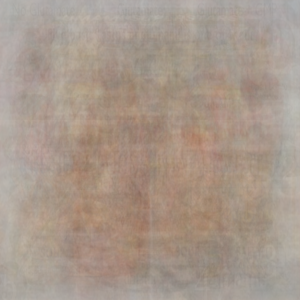

In [5]:
w2cv.run_analysis()
print(w2cv)
w2cv.colorgram

In [6]:
w2cv.save()

[2021-03-20 22:48:45,281] (compsyn.WordToColorVector)  INFO: saved 264.8KiB pickle to /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/unnamed/umami/w2cv.pickle


the `revision` attribute can be used to organize vectors created during a particular analysis iteration.

In [7]:
w2cv.revision = "notebook-example-0"
w2cv.save()

[2021-03-20 22:48:48,229] (compsyn.WordToColorVector)  INFO: saved 264.8KiB pickle to /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle


With the `Vector` object saved to disk, we can come back to our work later 

[2021-03-20 22:48:49,954] (compsyn.load_pickle)  INFO: loaded pickle from /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle
WordToColorVector(umami) for regional-differences/phase-0/shared_notebook_user
	jzazbz_dist = [9.6912392893723, 124.29782819569925, 0.5331998773851774, 158.33153803393142, 37.50937112516204, 320.02641199464165, 1.5631424638704223, 189.80076782096495]
	jzazbz_dist_std = [29.923388067182465, 136.14107233159373, 1.377660851776017, 127.25786506948863, 126.41870175320942, 217.38188009200033, 11.425845318167427, 124.09145642638009]


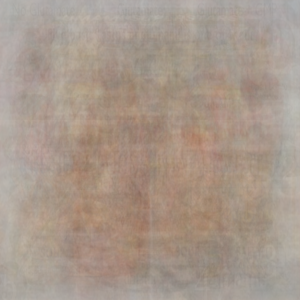

In [8]:
del w2cv # simulate leaving and coming back to our work later

# Re-use the Trial object and revision so that we can find the data
w2cv = WordToColorVector(label="umami", revision="notebook-example-0", trial=regional_trial)
w2cv.load()
print(w2cv)
w2cv.colorgram

# Some attributes may not be stored, to control the saved object size getting too large
# For instance, the larger jzazbz_vector, as well as the ImageData and ImageAnalysis objects are dropped.

The `Vector` class also knows how to store data in a shared backed (Using S3 object storage), but this requires configuration for accessing this backend. Set the following environment variables in the shell running this notebook to enable this feature.

- `COMPSYN_S3_ACCESS_KEY_ID`
- `COMPSYN_S3_SECRET_ACCESS_KEY`
- `COMPSYN_S3_BUCKET`
- `COMPSYN_S3_REGION_NAME`
- (optional) `COMPSYN_S3_ENDPOINT_URL` 

In [9]:
w2cv.push()

[2021-03-20 22:48:52,556] (compsyn.WordToColorVector)  INFO: saved 264.9KiB pickle to /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle


By default, push does not store raw images, but it can.

In [10]:
w2cv.push(include_raw_images=True)

[2021-03-20 22:49:12,316] (compsyn.WordToColorVector)  INFO: saved 264.9KiB pickle to /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle
[2021-03-20 22:49:12,903] (compsyn.WordToColorVector)  INFO: pushing raw images (ovewrite=False)...
[2021-03-20 22:49:49,651] (compsyn.WordToColorVector)  INFO: pushed 100 raw images to remote in 36 seconds


With the raw images stored remotely, we can now regenerate the entire analysis object from the data in S3.

In [11]:
for p in w2cv._local_raw_images_path.iterdir():
    p.unlink() # clear the downloads folder
del w2cv

w2cv = WordToColorVector(label="umami", revision="notebook-example-0", trial=regional_trial)
w2cv.pull(include_raw_images=True)
w2cv.run_analysis()

[2021-03-20 22:49:56,622] (compsyn.load_pickle)  INFO: loaded pickle from /Volumes/LACIE/compsyn/data/zth/regional-differences/vectors/notebook-example-0/umami/w2cv.pickle
[2021-03-20 22:49:56,623] (compsyn.WordToColorVector)  INFO: pulling raw images (ovewrite=False)...
[2021-03-20 22:50:14,658] (compsyn.WordToColorVector)  INFO: pulled 100 raw images from remote in 17 seconds
[2021-03-20 22:50:17,058] (compsyn.ImageAnalysis)  INFO: umami is being compressed.
